In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/MNIST/NonIID/DirichletPartition/Decentralized/MNIST_Dirichlet_Requirement.ipynb'

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1784) 2025-04-28 18:43:45.029276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1784) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1784) E0000 00:00:1745865825.089986    1784 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1784) E0000 00:00:1745865825.141422    1784 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1784) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 183090.22 examples/s]
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_rec

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4
(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.5497
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.9434
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 6 size: 2291
(ClientAppActor pid=1784) Partition 6 train size: 1832
(ClientAppActor pid=1784) Partition 6 test size: 459
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.9579
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.9682
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_r

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.9788
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.9780
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 6 size: 2291
(ClientAppActor pid=1784) Partition 6 train size: 1832
(ClientAppActor pid=1784) Partition 6 test size: 459
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.9794
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
Round 8: Test Accuracy: 0.9831
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(Client

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_r

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
Round 9: Test Accuracy: 0.9823
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Accuracy: 0.9861
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Test Accuracy: 0.9850
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Test Accuracy: 0.9866
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Accuracy: 0.9858
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Accuracy: 0.9862
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Accuracy: 0.9860
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 6 size: 2291
(ClientAppActor pid=1784) Partition 6 train size: 1832
(ClientAppActor pid=1784) Partition 6 test size: 459
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Test Accuracy: 0.9884
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Test Accuracy: 0.9847
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
Round 18: Test Accuracy: 0.9870


INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Client

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Accuracy: 0.9880
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Accuracy: 0.9867
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 6 size: 2291
(ClientAppActor pid=1784) Partition 6 train size: 1832
(ClientAppActor pid=1784) Partition 6 test size: 459
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Accuracy: 0.9840
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Accuracy: 0.9846
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Test Accuracy: 0.9880
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Accuracy: 0.9868
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Accuracy: 0.9859
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 6 size: 2291
(ClientAppActor pid=1784) Partition 6 train size: 1832
(ClientAppActor pid=1784) Partition 6 test size: 459
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Accuracy: 0.9845
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Test Accuracy: 0.9840
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_re

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Test Accuracy: 0.9828
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Test Accuracy: 0.9856
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Accuracy: 0.9848
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4
(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_

ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=1784, ip=172.28.0.12, actor_id=aad08a419f2e10c21c73ce5f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7d1487d35350>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/mnist/paths-info/77f3279092a1c1579b2250db8eafed0ad422088c

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=1784, ip=172.28.0.12, actor_id=aad08a419f2e10c21c73ce5f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7d1487d35350>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=message, cont

(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
Round 31: Test Accuracy: 0.9852
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 32: Test Accuracy: 0.9847
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_r

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Accuracy: 0.9870
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Test Accuracy: 0.9844
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=1784, ip=172.28.0.12, actor_id=aad08a419f2e10c21c73ce5f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7d1487d35350>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/mnist/paths-info/77f3279092a1c1579b2250db8eafed0ad422088c

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=1784, ip=172.28.0.12, actor_id=aad08a419f2e10c21c73ce5f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7d1487d35350>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=message, cont

(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 6 size: 2291
(ClientAppActor pid=1784) Partition 6 train size: 1832
(ClientAppActor pid=1784) Partition 6 test size: 459
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_re

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Test Accuracy: 0.9853
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Test Accuracy: 0.9856
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_re

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
Round 37: Test Accuracy: 0.9832
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Test Accuracy: 0.9859
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 6 size: 2291
(ClientAppActor pid=1784) Partition 6 train size: 1832
(ClientAppActor pid=1784) Partition 6 test size: 459
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Accuracy: 0.9844
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Test Accuracy: 0.9827
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Test Accuracy: 0.9836
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Test Accuracy: 0.9818
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3
(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Test Accuracy: 0.9829
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 6 size: 2291
(ClientAppActor pid=1784) Partition 6 train size: 1832
(ClientAppActor pid=1784) Partition 6 test size: 459
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
Round 44: Test Accuracy: 0.9833
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Test Accuracy: 0.9826
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=178

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Test Accuracy: 0.9865
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 12262609862224268919, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 6 size: 2291
(ClientAppActor pid=1784) Partition 6 train size: 1832
(ClientAppActor pid=1784) Partition 6 test size: 459
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Test Accuracy: 0.9838
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Test Accuracy: 0.9862
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=17

(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6930230026835089760, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 8134163273414936843, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6962972051789765913, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 3


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 3 size: 9621
(ClientAppActor pid=1784) Partition 3 train size: 7696
(ClientAppActor pid=1784) Partition 3 test size: 1925
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 16220487082845187036, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 6


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 6 size: 2291
(ClientAppActor pid=1784) Partition 6 train size: 1832
(ClientAppActor pid=1784) Partition 6 test size: 459
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5346616289682103314, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 4


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 4 size: 5106
(ClientAppActor pid=1784) Partition 4 train size: 4084
(ClientAppActor pid=1784) Partition 4 test size: 1022
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 14972293104474591379, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 9


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 9 size: 3310
(ClientAppActor pid=1784) Partition 9 train size: 2648
(ClientAppActor pid=1784) Partition 9 test size: 662


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Test Accuracy: 0.9827
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0


(ClientAppActor pid=1784) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1784) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:44:24 2025).


(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(ClientAppActor pid=1784) Partition 5 size: 4853
(ClientAppActor pid=1784) Partition 5 train size: 3882
(ClientAppActor pid=1784) Partition 5 test size: 971
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 3934657717036573749, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 5034417327387168010, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 0
(ClientAppActor pid=1784) Partition 0 size: 7682
(ClientAppActor pid=1784) Partition 0 train size: 6145
(ClientAppActor pid=1784) Partition 0 test size: 1537
(ClientAppActor pid=1784) Context data: {'run_id': 17093283086897830277, 'node_id': 6534149930028398785, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1784)   array_records={},
(ClientAppActor pid=1784)   metric_records={},
(ClientAppActor pid=1784)   config_records={}
(ClientAppActor pid=1784) ), 'run_config': {}}
(ClientAppActor pid=1784) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 2192.40s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06952446461705868
INFO :      		round 2: 0.00905546017732678
INFO :      		round 3: 0.0049413048420725286
INFO :      		round 4: 0.0034465687818142263
INFO :      		round 5: 0.002422695732682754
INFO :      		round 6: 0.002376875308563346
INFO :      		round 7: 0.0020682256755271754
INFO :      		round 8: 0.0017748679388273783
INFO :      		round 9: 0.0019113272548557793
INFO :      		round 10: 0.0014794573919073373
INFO :      		round 11: 0.0017537013891799592
INFO :      		round 12: 0.0014874630409620554
INFO :      		round 13: 0.001689079887930296
INFO :      		round 14: 0.0014744276621880162
INFO :      		round 15: 0.0016463385965504714
INFO :      		round 16: 0.0013467557355114907
INFO :      		round 17: 0.0015822792718239817
INFO :      		round 18: 0.0018845810252391

Round 50: Test Accuracy: 0.9845


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.5497
Round 2: 0.9434
Round 3: 0.9579
Round 4: 0.9682
Round 5: 0.9788
Round 6: 0.9780
Round 7: 0.9794
Round 8: 0.9831
Round 9: 0.9823
Round 10: 0.9861
Round 11: 0.9850
Round 12: 0.9866
Round 13: 0.9858
Round 14: 0.9862
Round 15: 0.9860
Round 16: 0.9884
Round 17: 0.9847
Round 18: 0.9870
Round 19: 0.9880
Round 20: 0.9867
Round 21: 0.9840
Round 22: 0.9846
Round 23: 0.9880
Round 24: 0.9868
Round 25: 0.9859
Round 26: 0.9845
Round 27: 0.9840
Round 28: 0.9828
Round 29: 0.9856
Round 30: 0.9848
Round 31: 0.9852
Round 32: 0.9847
Round 33: 0.9870
Round 34: 0.9844
Round 35: 0.9853
Round 36: 0.9856
Round 37: 0.9832
Round 38: 0.9859
Round 39: 0.9844
Round 40: 0.9827
Round 41: 0.9836
Round 42: 0.9818
Round 43: 0.9829
Round 44: 0.9833
Round 45: 0.9826
Round 46: 0.9865
Round 47: 0.9838
Round 48: 0.9862
Round 49: 0.9827
Round 50: 0.9845



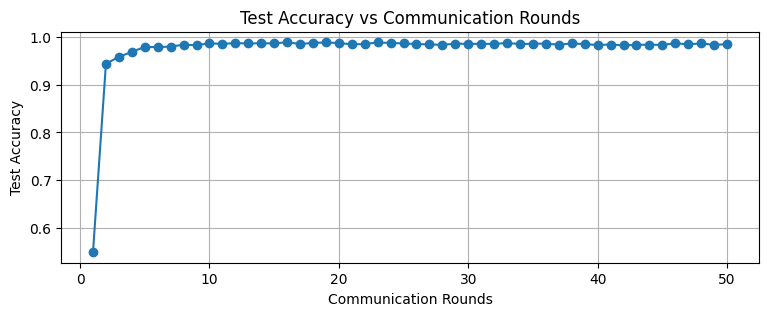

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

In [ ]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

In [ ]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    # Passing initial_parameters to FedAvg strategy prevents Flower from asking one of the clients.
    initial_parameters=ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

(pid=22373) 2025-04-19 15:26:13.547408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=22373) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=22373) E0000 00:00:1745076373.643390   22373 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=22372) E0000 00:00:1745076373.601108   22372 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=22373) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=22373) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=22373) see the 

(ClientAppActor pid=22373) Context data: {'run_id': 5367222656170028308, 'node_id': 12803175659884548704, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=22373)   array_records={},
(ClientAppActor pid=22373)   metric_records={},
(ClientAppActor pid=22373)   config_records={}
(ClientAppActor pid=22373) ), 'run_config': {}}
(ClientAppActor pid=22373) Using partition_id: 4
(ClientAppActor pid=22373) Partition 4 size: 5106
(ClientAppActor pid=22373) Partition 4 train size: 4084
(ClientAppActor pid=22373) Partition 4 test size: 1022
(ClientAppActor pid=22372) Context data: {'run_id': 5367222656170028308, 'node_id': 1786626510230001657, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=22372)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=22372)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=22372)   config_records={} [r

(ClientAppActor pid=22372) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=22372) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=22372) see the appropriate new directories, set the environment variable
(ClientAppActor pid=22372) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=22372) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=22372)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.7702
Round 2: 0.9432
Round 3: 0.9727
Round 4: 0.9735
Round 5: 0.9783
Round 6: 0.9825
Round 7: 0.9820
Round 8: 0.9862
Round 9: 0.9827
Round 10: 0.9856



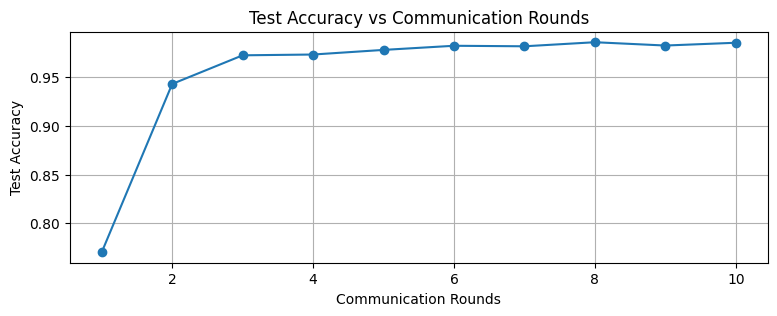

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()